# Latent Dirichlet Allocation models on BBC data

### Model 1. Scikit-learn

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import PorterStemmer
import spacy
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim
import re
from bertopic import BERTopic
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer


stops = stopwords.words('english')
stops.extend(['has', 'been', 're', 'com', 'edu', 'use', 'said', 'would', 'could', 'told', 'also', 'one', 'two', 'mr', 'new', 'year'])

In [2]:
# Read the data
df = pd.read_csv('bbc_text_cls.csv')

# # Remove missing values
# df.dropna(axis = 0, how ='any', inplace=True)

# # Add num words column
# df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
# max_review_data_sentence_length  = df['Num_words_text'].max()

# # Create a mask to filter out long reviews and very short ones
# mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
# df = df[mask]

# Remove punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# Remove \n characters
df['text'] = df['text'].str.replace('\n', ' ')

# Remove digits and non-alphanumeric characters
df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')

# Lowercase the text
df['text'] = df['text'].str.lower()

# # Normalize whitespace
# def normalize_whitespace(text):
#     text = re.sub('[\s]+', ' ', text)
#     return text

# df['text'] = df['text'].map(normalize_whitespace)

# Remove stopwords
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stops])
    return text

df['text'] = df['text'].apply(remove_stopwords)

# Lemmatization
def lemmatization(text, allowed_postags = ['NOUN', 'ADJ']):
  doc = nlp(''.join(text))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
  return ' '.join(doc)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
df['text'] = df['text'].map(lemmatization)

# Stemming
def stemming(text):
  doc = [PorterStemmer().stem(w).strip() for w in text.split()]
  return ' '.join(doc)

df['text'] = df['text'].map(stemming)

# # Remove words that contain digits
# pattern = re.compile(r'\b\w*\d\w*\b')
# df['text'] = df['text'].apply(lambda x: pattern.sub('', x))

# # Normalize whitespace again
# df['text'] = df['text'].map(normalize_whitespace)

<>:25: DeprecationWarning: invalid escape sequence \s
<>:25: DeprecationWarning: invalid escape sequence \s
C:\Users\User\AppData\Local\Temp\ipykernel_21880\2014397279.py:25: DeprecationWarning: invalid escape sequence \s
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')
C:\Users\User\AppData\Local\Temp\ipykernel_21880\2014397279.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')


In [3]:
df['labels'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

In [4]:
# Create count vectorizer
vectorizer = CountVectorizer(stop_words = list(stops),
                            # min_df = 20,
                            # max_df = 0.2,
                            # max_features = 5000,
                            # ngram_range = (1,3)
                            )
X = vectorizer.fit_transform(df['text'])

# Create an LDA model
lda = LatentDirichletAllocation(n_components = 5, random_state = 12345, max_iter = 50)
lda.fit(X)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=12345)

In [5]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

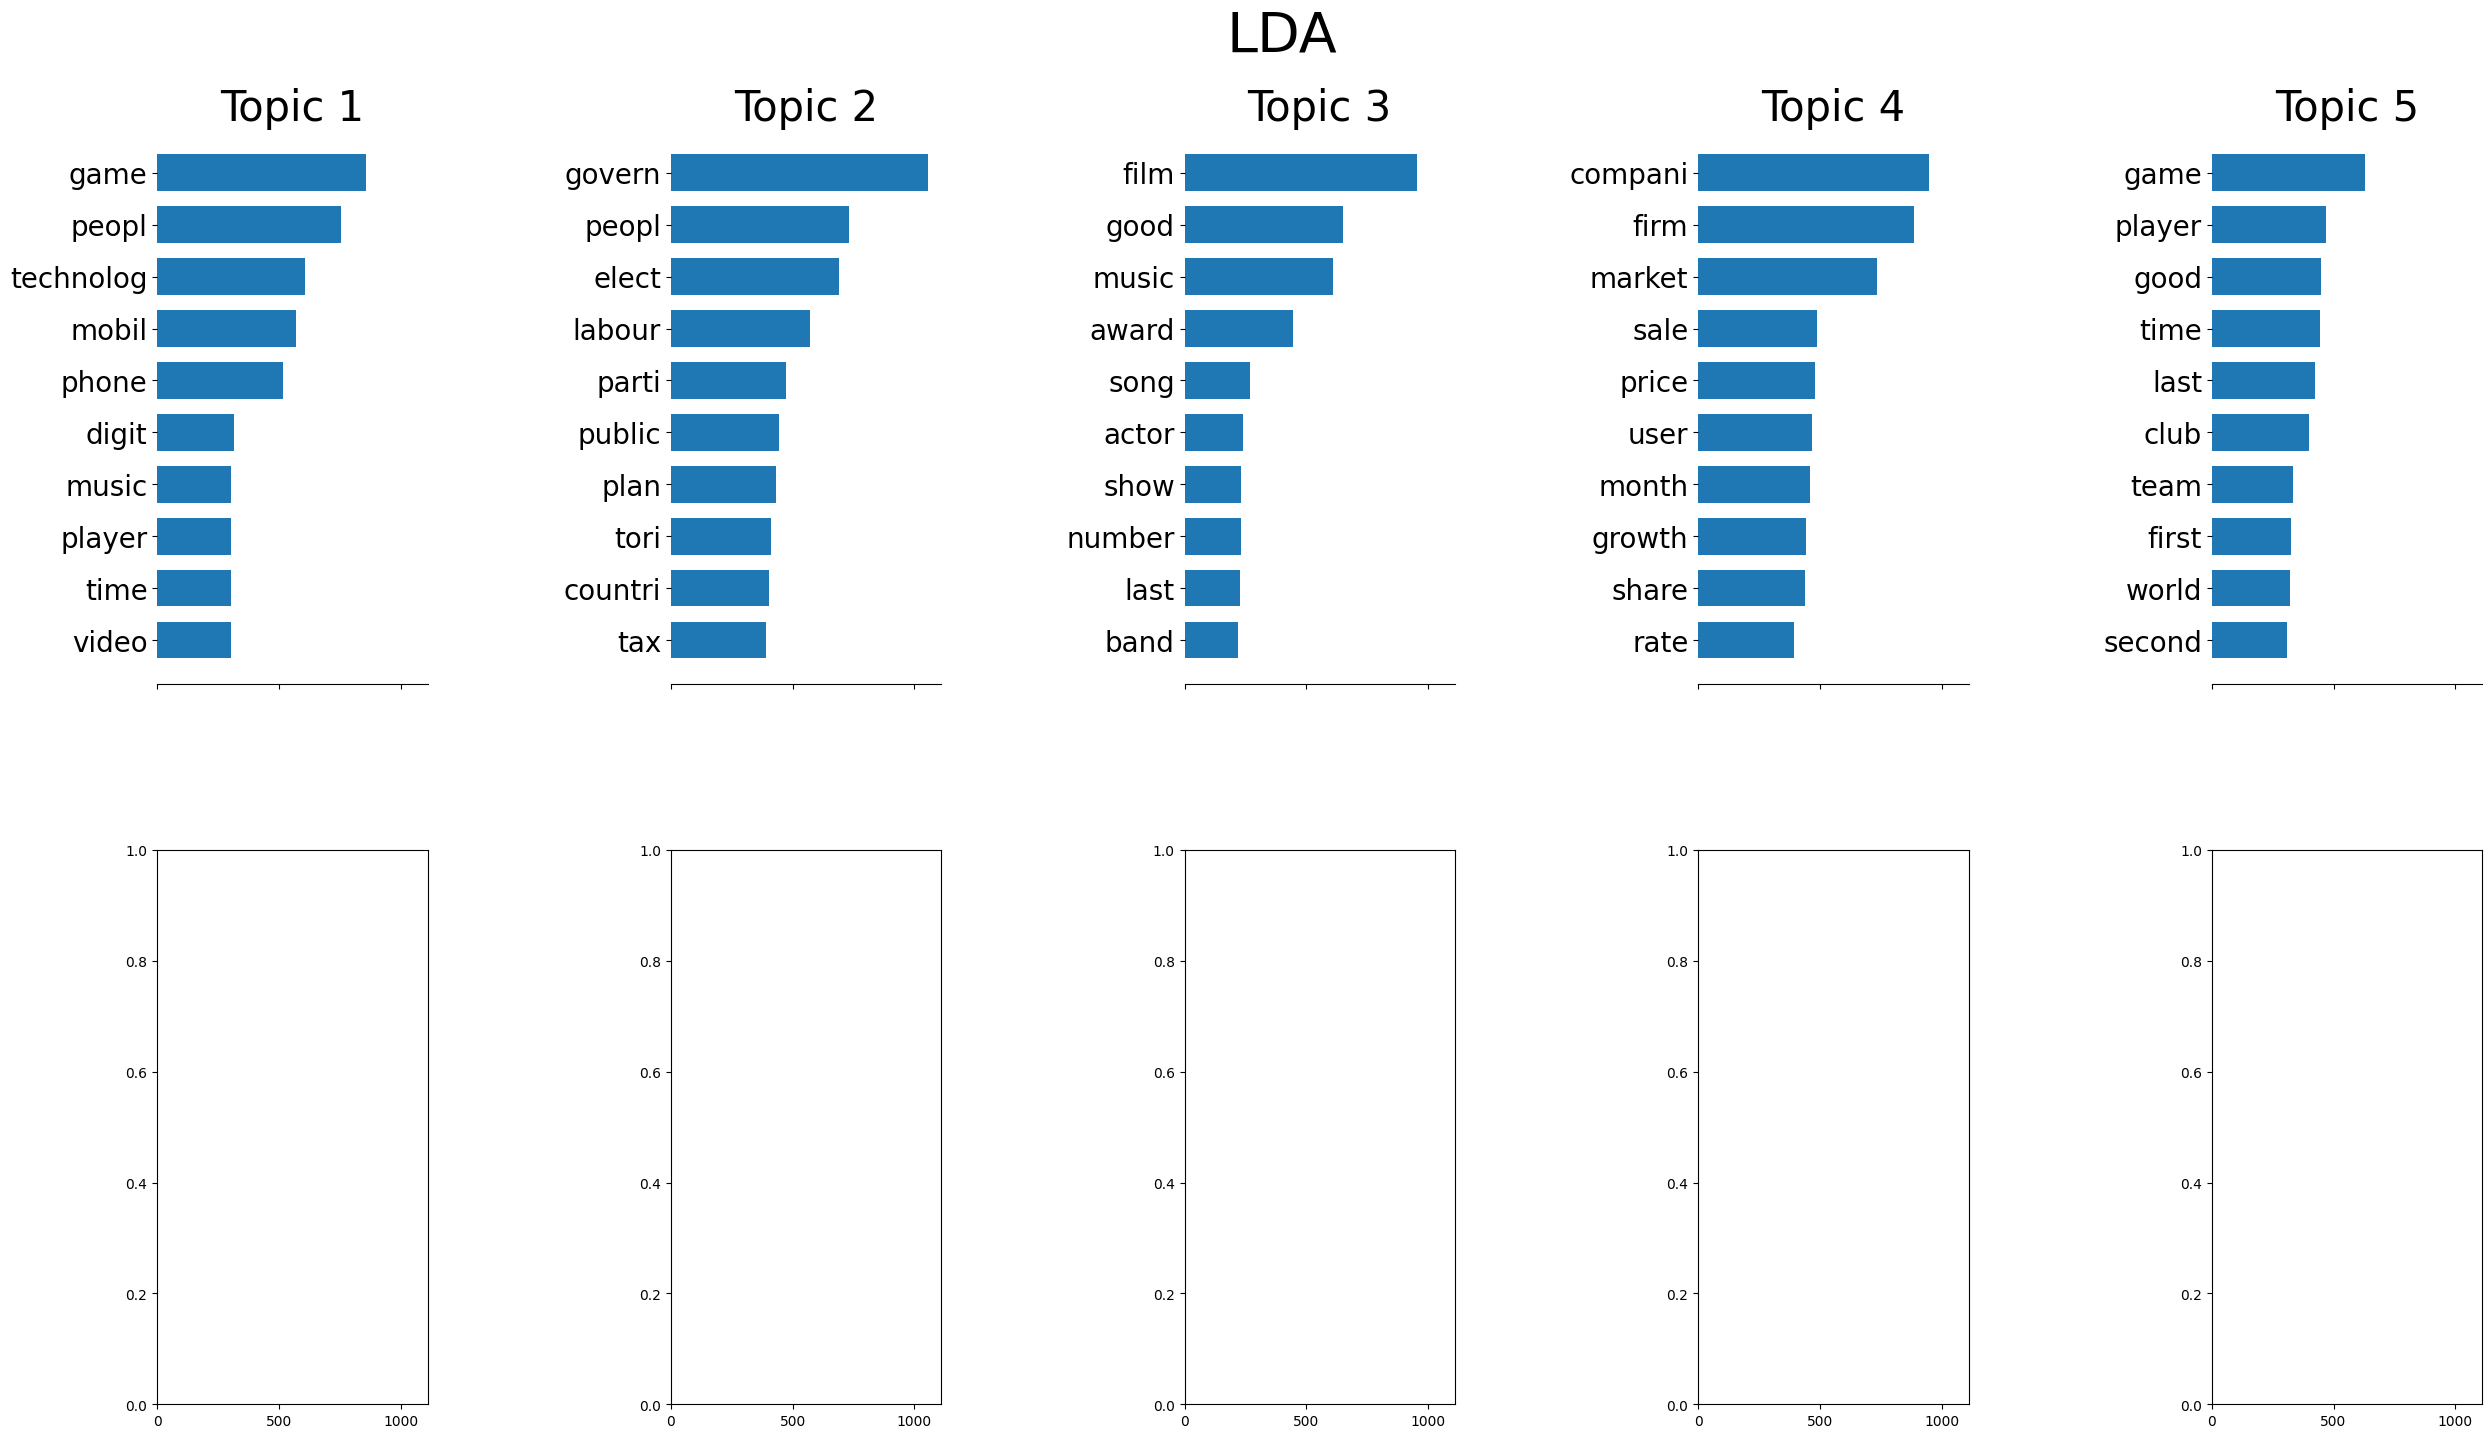

In [6]:
# Words per topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

In [7]:
# Latent variables extraction
Z = lda.transform(X)

Text(0.5, 1.0, 'True label: sport')

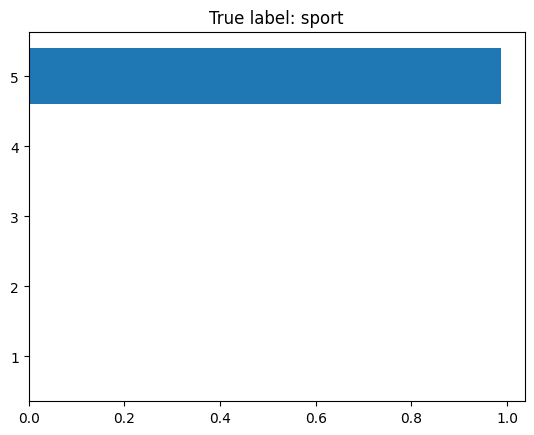

In [8]:
# Sample topic
np.random.seed(0)

i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(5) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [9]:
# # Associated article
# def wrap(x):
#   return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

# print(wrap(df.iloc[i]['text']))

Text(0.5, 1.0, 'True label: entertainment')

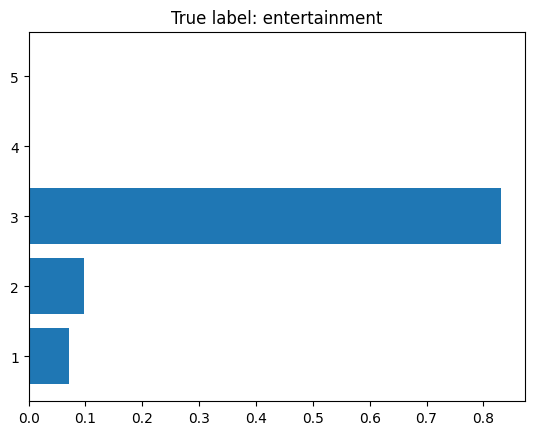

In [10]:
# Sample topic n2
i = np.random.choice(len(df))
z = Z[i]

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [11]:
# # Associated article n2
# print(wrap(df.iloc[i]['text']))

### Model 2. Gensim

In [12]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name):
  cv = CountVectorizer(analyzer = 'word')
  data = cv.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df, 'text')

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

In [13]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


texts = words
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [15]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.018*"peopl" + 0.016*"technolog" + 0.015*"mobil" + 0.014*"phone" + '
  '0.012*"servic" + 0.010*"music" + 0.009*"digit" + 0.008*"user" + '
  '0.008*"comput" + 0.008*"pc"'),
 (1,
  '0.013*"site" + 0.010*"search" + 0.010*"peopl" + 0.010*"email" + '
  '0.010*"attack" + 0.010*"compani" + 0.010*"firm" + 0.009*"softwar" + '
  '0.008*"inform" + 0.008*"legal"'),
 (2,
  '0.013*"govern" + 0.008*"elect" + 0.006*"peopl" + 0.006*"labour" + '
  '0.006*"market" + 0.006*"plan" + 0.005*"countri" + 0.005*"last" + '
  '0.005*"parti" + 0.005*"public"'),
 (3,
  '0.034*"game" + 0.013*"good" + 0.010*"player" + 0.009*"film" + 0.008*"time" '
  '+ 0.008*"last" + 0.007*"titl" + 0.007*"world" + 0.006*"first" + '
  '0.006*"award"'),
 (4,
  '0.012*"music" + 0.011*"peopl" + 0.009*"time" + 0.008*"year" + 0.007*"world" '
  '+ 0.007*"film" + 0.005*"good" + 0.005*"life" + 0.005*"day" + 0.005*"game"')]


In [16]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.027049  0.112263       1        1  35.430365
3      0.205123  0.080329       2        1  23.105600
0     -0.099163 -0.154118       3        1  15.730399
4      0.104777 -0.124072       4        1  13.529423
1     -0.183689  0.085599       5        1  12.204213, topic_info=           Term         Freq        Total Category  logprob  loglift
858        game  2292.000000  2292.000000  Default  30.0000  30.0000
685   technolog   663.000000   663.000000  Default  29.0000  29.0000
770       mobil   573.000000   573.000000  Default  28.0000  28.0000
820       phone   563.000000   563.000000  Default  27.0000  27.0000
58        music   785.000000   785.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1900       bill   115.924901   221.494872   Topic5  -5.5652   1.4559
811      messag   118.540052   258.410027   Topic5  -5.5429   1.3241
139        mani   132.613630   806.592588   Topic5  -5.4307   0.2980
1928     comput   118.336355   464.207215   Topic5  -5.5446   0.7366
188       group   116.449838   539.415793   Topic5  -5.5607   0.5704

[371 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
757       1  0.179021  access
757       3  0.638248  access
757       4  0.054485  access
757       5  0.128428  access
167       1  0.230949  action
...     ...       ...     ...
392       2  0.290464    year
392       3  0.084448    year
392       4  0.240352    year
392       5  0.031552    year
219       5  0.963980    yuko

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [17]:
perplexity = lda_model.log_perplexity(corpus)
perplexity

-7.7026186920980555

In [18]:
# Model evaluation with Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = words, dictionary = id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.4764466997069098


In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                                                             chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = model.log_perplexity(corpus)
        perplexity_list.append(perplexity)

    return model_list, coherence_values, perplexity_list
  
model_list, coherence_values, perplexity_list = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=2, limit=10, step=1)

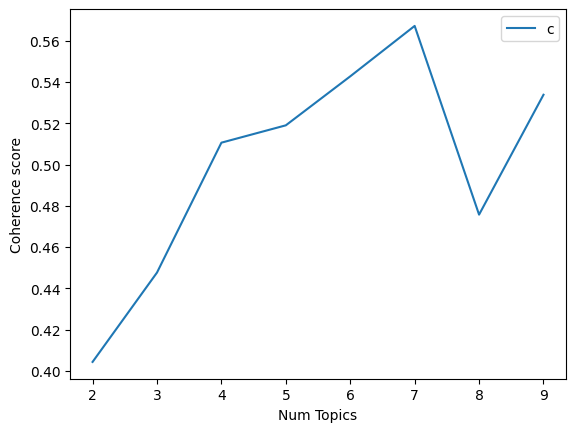

Num Topics = 2  has Coherence Value of 0.4043
Num Topics = 3  has Coherence Value of 0.4477
Num Topics = 4  has Coherence Value of 0.5106
Num Topics = 5  has Coherence Value of 0.519
Num Topics = 6  has Coherence Value of 0.5428
Num Topics = 7  has Coherence Value of 0.5672
Num Topics = 8  has Coherence Value of 0.4757
Num Topics = 9  has Coherence Value of 0.5338


In [20]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

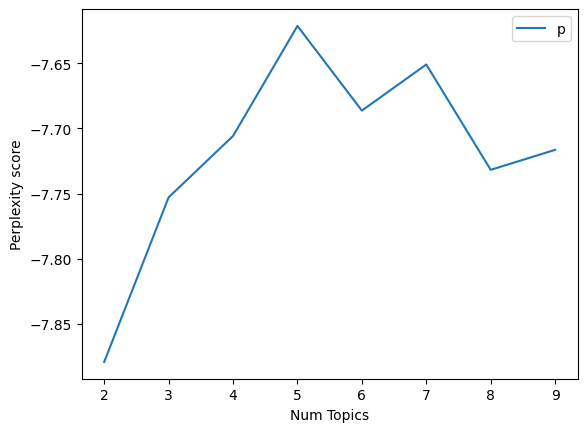

Num Topics = 2  has Perplexity Value of -7.8792
Num Topics = 3  has Perplexity Value of -7.7529
Num Topics = 4  has Perplexity Value of -7.7059
Num Topics = 5  has Perplexity Value of -7.6214
Num Topics = 6  has Perplexity Value of -7.6863
Num Topics = 7  has Perplexity Value of -7.651
Num Topics = 8  has Perplexity Value of -7.7318
Num Topics = 9  has Perplexity Value of -7.7165


In [21]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_list)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

# Print the perplexity scores
for m, cv in zip(x, perplexity_list):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

In [22]:
best_num = 4

# Select the model and print the topics
optimal_model = model_list[best_num-2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.012*"govern" + 0.009*"peopl" + 0.007*"elect" + 0.006*"labour" + 0.006*"public" + 0.005*"law" + 0.005*"plan" + 0.005*"countri" + 0.005*"parti" + 0.004*"issu"'),
 (1,
  '0.012*"firm" + 0.010*"compani" + 0.010*"net" + 0.010*"secur" + 0.010*"softwar" + 0.010*"user" + 0.009*"peopl" + 0.008*"market" + 0.008*"servic" + 0.008*"viru"'),
 (2,
  '0.013*"good" + 0.012*"game" + 0.009*"film" + 0.008*"time" + 0.007*"last" + 0.007*"year" + 0.006*"player" + 0.006*"world" + 0.006*"first" + 0.005*"award"'),
 (3,
  '0.017*"peopl" + 0.015*"game" + 0.014*"technolog" + 0.013*"mobil" + 0.011*"phone" + 0.011*"music" + 0.008*"servic" + 0.008*"digit" + 0.007*"player" + 0.007*"video"')]

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054890 -0.171033       1        1  34.868673
2     -0.197175  0.075662       2        1  30.079159
3      0.085330  0.127400       3        1  18.111365
1      0.166735 -0.032029       4        1  16.940803, topic_info=          Term         Freq        Total Category  logprob  loglift
858       game  1565.000000  1565.000000  Default  30.0000  30.0000
127     govern  1087.000000  1087.000000  Default  29.0000  29.0000
770      mobil   607.000000   607.000000  Default  28.0000  28.0000
685  technolog   742.000000   742.000000  Default  27.0000  27.0000
820      phone   674.000000   674.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
139       mani   244.101580   829.158566   Topic4  -5.1485   0.5526
256     number   232.021193   843.193876   Topic4  -5.1992   0.4851
43        high   190.765080   486.261738   Topic4  -5.3950   0.8397
452     system   188.160749   649.252764   Topic4  -5.4088   0.5369
302       last   187.122180  1157.065603   Topic4  -5.4143  -0.0464

[305 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4578      2  0.958708    actor
4578      3  0.040580    actor
5457      2  0.994947  actress
9         1  0.055862  analyst
9         3  0.283035  analyst
...     ...       ...      ...
7284      4  0.991180     worm
392       1  0.294800     year
392       2  0.496012     year
392       3  0.119792     year
392       4  0.089844     year

[512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

### Model 2.1 Gensim model with TF-IDF (alternative approach)

In [24]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 11.119589620741124),
 (1, 11.119589620741124),
 (2, 9.119589620741122),
 (3, 11.119589620741124),
 (4, 4.299410658325935),
 (5, 6.212699025132605),
 (6, 6.660158002103826),
 (7, 11.743324214595075),
 (8, 4.200726383466528),
 (9, 3.1712223891564446),
 (10, 10.119589620741122),
 (11, 11.119589620741124),
 (12, 2.069741071290561),
 (13, 4.312234698683518),
 (14, 9.119589620741122),
 (15, 4.852803080046221),
 (16, 3.8249688718494954),
 (17, 3.5196767785539946),
 (18, 2.1083623653178685),
 (19, 10.119589620741122),
 (20, 4.660158002103826),
 (21, 5.910136255112173),
 (22, 8.377704566356472),
 (23, 7.312234698683518),
 (24, 5.212699025132604),
 (25, 5.142309697241206),
 (26, 3.806706665456767),
 (27, 6.212699025132605),
 (28, 7.119589620741122),
 (29, 4.834187401878874),
 (30, 6.064253558981567),
 (31, 3.3058084295240855),
 (32, 3.6849613931043983),
 (33, 2.3713967711516624),
 (34, 6.364702118577654),
 (35, 5.910136255112173),
 (36, 13.559030335661985),
 (37, 3.939680530726188),
 (38, 8

In [25]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [26]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.010*"mobil" + 0.010*"phone" + 0.007*"technolog" + 0.006*"servic" + '
  '0.005*"game" + 0.005*"peopl" + 0.005*"devic" + 0.005*"digit" + '
  '0.004*"search" + 0.004*"user"'),
 (1,
  '0.006*"game" + 0.005*"good" + 0.005*"player" + 0.005*"film" + 0.004*"club" '
  '+ 0.004*"match" + 0.004*"award" + 0.004*"team" + 0.004*"side" + '
  '0.004*"win"'),
 (2,
  '0.006*"price" + 0.006*"growth" + 0.005*"economi" + 0.005*"rate" + '
  '0.005*"market" + 0.005*"sale" + 0.005*"profit" + 0.004*"econom" + '
  '0.004*"oil" + 0.004*"bank"'),
 (3,
  '0.007*"elect" + 0.006*"labour" + 0.006*"govern" + 0.005*"tori" + '
  '0.005*"parti" + 0.004*"law" + 0.003*"polit" + 0.003*"minist" + '
  '0.003*"campaign" + 0.003*"plan"'),
 (4,
  '0.009*"music" + 0.007*"film" + 0.005*"song" + 0.005*"softwar" + '
  '0.005*"band" + 0.004*"viru" + 0.004*"program" + 0.004*"email" + '
  '0.004*"site" + 0.004*"album"')]


In [27]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.060235  0.141860       1        1  25.083803
1     -0.239705  0.083630       2        1  20.197056
2      0.151445  0.037053       3        1  18.956906
0      0.115229 -0.084001       4        1  18.574366
4     -0.087205 -0.178541       5        1  17.187869, topic_info=         Term         Freq        Total Category  logprob  loglift
770     mobil  2400.000000  2400.000000  Default  30.0000  30.0000
820     phone  2342.000000  2342.000000  Default  29.0000  29.0000
58      music  2831.000000  2831.000000  Default  28.0000  28.0000
30       film  3059.000000  3059.000000  Default  27.0000  27.0000
364     elect  2279.000000  2279.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2248     show   542.204597  1199.133648   Topic5  -5.9923   0.9673
386    record   566.387683  1436.422557   Topic5  -5.9487   0.8303
1869  network   565.273977  1483.194756   Topic5  -5.9507   0.7963
248      good   573.872148  2530.442377   Topic5  -5.9356   0.2772
256    number   518.413552  1763.485737   Topic5  -6.0372   0.5367

[400 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
757        1  0.180198    access
757        2  0.000996    access
757        3  0.109513    access
757        4  0.624222    access
757        5  0.085619    access
...      ...       ...       ...
10955      1  0.997355      wolf
1653       4  0.994712  worldcom
7284       5  0.994832      worm
356        3  0.997234       yen
219        1  0.998783      yuko

[965 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

### Model 3. BERTopic

In [41]:

# OPTIONAL CODE! MODEL COMPONENTS EXAMPLES
# ----------------------------------------------------------------------------------------

# embedding_model_1 = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# embedding_model_2 = SentenceTransformer('allenai-specter')
# umap_model_1 = PCA(n_components = 5)
# umap_model_2 = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine', random_state = 100)
# cluster_model_1 = KMeans(n_clusters = 50)
# cluster_model_2 = HDBSCAN(min_cluster_size=80, min_samples=40, metric = 'euclidean', gen_min_span_tree=True, prediction_data=True)
# vectorizer_model_1 = CountVectorizer(ngram_range = (1,3), stop_words = 'english')
# ctfidf_model_1 = ClassTfidfTransformer(bm25_weighting = True)



# topic_model = BERTopic(
#   umap_model = (umap_model_1, umap_model_2),
#                        embedding_model = (embedding_model_1, embedding_model_2),
#                        hdbscan_model = (cluster_model_1, cluster_model_2),
#                        vectorizer_model = (vectorizer_model_1),
#                        ctfidf_model = (ctfidf_model_1),
#                        calculate_probabilities = True,
#                        verbose = True,
#                        language = 'english')

# ----------------------------------------------------------------------------------------


topic_model = BERTopic(embedding_model = 'all-miniLM-L6-v2', calculate_probabilities = True)

topics, probs = topic_model.fit_transform(df['text'])

In [42]:
topic_model.get_topic_info()

Topic  Count                             Name
0      -1     99  -1_tv_dvd_technolog_highdefinit
1       0    940      0_govern_elect_labour_peopl
2       1    342          1_club_player_game_side
3       2    134          2_film_actor_good_award
4       3    113         3_site_user_email_search
5       4    102          4_music_band_song_album
6       5     87        5_open_seed_match_roddick
7       6     71  6_technolog_comput_gadget_devic
8       7     61     7_race_indoor_olymp_champion
9       8     54         8_game_gamer_consol_titl
10      9     45      9_mobil_phone_camera_servic
11     10     40          10_show_tv_seri_channel
12     11     33        11_athlet_drug_iaaf_greek
13     12     25  12_broadband_servic_net_connect
14     13     21      13_film_festiv_music_singer
15     14     21   14_music_player_digit_download
16     15     14   15_file_system_network_bittorr
17     16     12       16_book_novel_winner_prize
18     17     11     17_patent_softwar_law_invent

In [43]:
topic_number = 0
topic_model.get_topic(0)

[('govern', 0.025713186080743997),
 ('elect', 0.018883465194214626),
 ('labour', 0.01671775318540039),
 ('peopl', 0.015254967322065799),
 ('market', 0.014824154241202672),
 ('compani', 0.014644830764531871),
 ('plan', 0.014316758612497852),
 ('economi', 0.014168885308187813),
 ('countri', 0.013935405288994746),
 ('parti', 0.013685598266992121)]

In [44]:
topic_number = 0
topic_model.get_representative_docs(0)

['elect gener elect good chanc pressur group real impact govern polici lobbi plan sure caus spring poll state pension pension credit guarante level mani pension disadvantag current system pension poverti line gener peopl live poverti pension manifesto candid constitu top issu pension issu support respons result constitu way politician fact m voter countri like vote section societi true swing voter pension conserv labour guarante vote labour govern time vote pension big elect issu govern public adair turner full report issu least gener pension system world govern aviat environ specif plan polit parti incumb mp variou local group particular area nation brief larg demonstr success issu public conscious extent difficult elect import public mind big issu hunt bill act high court action way court side appeal plumb time ban forc februari court compens lot legal territori engag minist intellig rural engag difficult intimidatori whole group angri housewif cours element peopl angri violenc fall 

In [45]:
assigned_topics_df = pd.DataFrame({'topic':topics, 'document': df['text']})

In [46]:
topic_model.visualize_barchart(top_n_topics = 8)

In [47]:
topic_model.visualize_topics()

In [67]:
topic_model.visualize_heatmap(n_clusters = 6)

In [49]:
topic_model.visualize_hierarchy()

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [51]:
topic_number = 0
topic_model.visualize_distribution(probs[topic_number])

In [54]:
new_doc = 'This is my new document about sport'

num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_doc, top_n = num_of_topics)

print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity, 2)}')

for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(topic_model.get_topic(similar_topics[i]))

The top 3 similar topics are [11, 7, 16], and the similarities are [0.35 0.33 0.32]
The top keywords for topic 11 are:
[('athlet', 0.12029541644376514), ('drug', 0.11289934835289839), ('iaaf', 0.09295362243562748), ('greek', 0.08944575641513348), ('test', 0.08686357056687041), ('thanou', 0.07329598740939704), ('sprinter', 0.0708356714402709), ('cont', 0.05525269213996573), ('olymp', 0.053013483637695855), ('tribun', 0.05201650719376564)]
The top keywords for topic 7 are:
[('race', 0.09016076147928569), ('indoor', 0.078649956187382), ('olymp', 0.0702064204961891), ('champion', 0.05614449957622342), ('world', 0.05446122192419492), ('second', 0.04866157415585059), ('athlet', 0.04845453010733182), ('men', 0.04616575818858002), ('titl', 0.04463975960362565), ('record', 0.04175203806068048)]
The top keywords for topic 16 are:
[('book', 0.1615149728792661), ('novel', 0.10595380392669151), ('winner', 0.08339444869675802), ('prize', 0.0683823111895073), ('award', 0.06152611925162131), ('author'

In [55]:
similar_topics, similarity = topic_model.find_topics('gymnastics', top_n = 3)

for sim_topic in similar_topics:
  print(sim_topic)
  print(topic_model.get_topic(sim_topic))

11
[('athlet', 0.12029541644376514), ('drug', 0.11289934835289839), ('iaaf', 0.09295362243562748), ('greek', 0.08944575641513348), ('test', 0.08686357056687041), ('thanou', 0.07329598740939704), ('sprinter', 0.0708356714402709), ('cont', 0.05525269213996573), ('olymp', 0.053013483637695855), ('tribun', 0.05201650719376564)]
7
[('race', 0.09016076147928569), ('indoor', 0.078649956187382), ('olymp', 0.0702064204961891), ('champion', 0.05614449957622342), ('world', 0.05446122192419492), ('second', 0.04866157415585059), ('athlet', 0.04845453010733182), ('men', 0.04616575818858002), ('titl', 0.04463975960362565), ('record', 0.04175203806068048)]
13
[('film', 0.1172837100507882), ('festiv', 0.08748158132981254), ('music', 0.08570802251773432), ('singer', 0.07509445419420534), ('produc', 0.05544055735189669), ('stori', 0.05273106329287812), ('life', 0.05234914119276827), ('melcher', 0.04136908288793041), ('daylewi', 0.04071058650867883), ('godzilla', 0.03685122168918821)]


In [64]:
topic_labels = topic_model.generate_topic_labels(nr_words = 3, 
                                                 topic_prefix = False,
                                                 word_length = 15,
                                                 separator = ' - ')
topic_model.set_topic_labels(topic_labels)
topic_model.set_topic_labels({0: 'Politics', 8: 'Sports'})
topic_model.get_topic_info().head(10)

Topic  Count                             Name                   CustomName
0     -1     99  -1_tv_dvd_technolog_highdefinit         tv - dvd - technolog
1      0    940      0_govern_elect_labour_peopl                     Politics
2      1    342          1_club_player_game_side         club - player - game
3      2    134          2_film_actor_good_award          film - actor - good
4      3    113         3_site_user_email_search          site - user - email
5      4    102          4_music_band_song_album          music - band - song
6      5     87        5_open_seed_match_roddick          open - seed - match
7      6     71  6_technolog_comput_gadget_devic  technolog - comput - gadget
8      7     61     7_race_indoor_olymp_champion        race - indoor - olymp
9      8     54         8_game_gamer_consol_titl                       Sports

In [66]:
# EXTRA PARAMETERS

# Change n-grams without re-fitting our entire model
topic_model.update_topics(df['text'], n_gram_range=(1,3))

# Merge specific topics
topic_model.merge_topics(df['text'], topics_to_merge = [1, 8, 12])

# Reduce the number of topics by iteratively merging them
topic_model.reduce_topics(df['text'], nr_topics = 5)

In [68]:
topic_model.visualize_documents(df['text'],
                               topics = list(range(10)),
                               custom_labels = True,
                               height = 600)

#### Things to try to improve LDA:
* Try changing hyperparameters of LDA algorithm
* Try reducing/increasing the number of POS tags
* Try different stemmers/lemmatizers
* Try removing/leaving digits or even more radical - remove words containing numbers
* Try with/without stemming
* Try different alpha/beta parameters of LDA
* Try removing words with len < 2 or 3
* To choose the right number of topics for LDA compare the goodness of fit for various

#### LDA Parameters
* chunksize - Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* passes/iterations - It is important to set the number of “passes” and “iterations” high enough.
* 2 Dirichlet hyperparameters: alpha and beta (or sometimes eta) - try arranging those as follows list(np.arange(0.01, 1, 0.3))  and try different params from there.
* To test different combinations of hyperparameters use nested for loops.

#### Things to try to improve BERTopic
* Try using different ngram ranges
* Reduce the number of topics
* Merge topics
* Specify the topics that you want to find using case knowledge
* Try using topic_model.visualize_term_rank(log_scale = True/False) to determine the minimum number of words to represent a topic properly.
* It might be a good idea to do some basic preprocessing, such as removing stopwords and lemmatization/stemming
* Try hyperparameter tuning on the UMAP model
* Try hyperparameter tuning on the HDBscan model

#### BERTopic parameters
* embedding_model = 'all-miniLM-L6-v2' or 'paraphrase-MiniLM-L12-v2'. In fact, this is an important parameter that you can adjust simply by picking a model from https://sbert.net/docs/pretrained_models.html Have a look at the speed and performance of each model and adjust to your needs.
* min_topic_size - minimum number of docs per topic to create a new topic category


In [61]:
!git push

To github.com:CalesSla/NLP_TopicModelling.git
   ffba91e..4c09817  master -> master
